In [1]:
import sys
sys.path.insert(0, "/data/leuven/347/vsc34783/DeepTopic+")
import pandas as pd
import numpy as np
import pybedtools
import utils
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()
tf.compat.v1.disable_eager_execution()
import pickle

2023-10-20 12:02:30.313162: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
/staging/leuven/stg_00002/lcb/nkemp/software/anaconda3/envs/deeplearning_py38_tf241/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
!nvidia-smi

Wed Oct 11 12:59:41 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:18:00.0 Off |                    0 |
| N/A   31C    P0    62W / 500W |      0MiB / 81920MiB |      0%   E. Process |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Load the consensuspeaks file

Copy your peak file to your working directory

In [2]:
!cp /staging/leuven/stg_00002/lcb/lcb_projects/biccn_okt_2023/analysis/cistopic/Mouse/outs/consensus_peaks/consensus_peaks_bicnn.bed tmp.bed

The orginal peak file has 500 bp peaks. We extend it to 2114 and store it in a new bed file.

In [3]:
!awk -v value=807 '{print $1, $2 - value, $3 + value, $4}' tmp.bed > tmp2.bed
!tr ' ' '\t' < tmp2.bed > consensus_peaks.mouse.2114.bed
!rm tmp.bed
!rm tmp2.bed

We filter out regions that have a negative starting coordinate which can occur from the previous sequence extension.

In [4]:
!awk '($2 < 0) || ($3 < 0) { print "Negative coordinate found on line:", NR > "/dev/stderr"; next } 1' consensus_peaks.mouse.2114.bed > tmp.bed && mv tmp.bed consensus_peaks.mouse.2114.filt.bed


We do the same filtering but now for regions which exceed the bounds of a chromosome size

In [5]:
!filterBedChromSizes.sh -b "consensus_peaks.mouse.2114.filt.bed" -c "/staging/leuven/res_00001/genomes/mus_musculus/mm10_ucsc/fasta/mm10.chrom.sizes"

/bin/bash: ./filterBedChromSizes.sh: Permission denied


We also make a bed file with 1000 bp peaks which is necessary for our target vector calculation

In [6]:
!awk -v value=557 '{print $1, $2 + value, $3 - value, $4}' consensus_peaks.mouse.2114.filt.bed > tmp.bed
!tr ' ' '\t' < tmp.bed > consensus_peaks.mouse.1000.filt.bed
!rm tmp.bed

In [7]:
!awk '{printf "%s\t%s\t%s\t%s:%s-%s\n", $1, $2, $3, $1, $2, $3}' consensus_peaks.mouse.2114.filt.bed > tmp.bed
!mv tmp.bed consensus_peaks.mouse.2114.filt.bed
!awk '{printf "%s\t%s\t%s\t%s:%s-%s\n", $1, $2, $3, $1, $2, $3}' consensus_peaks.mouse.1000.filt.bed > tmp.bed
!mv tmp.bed consensus_peaks.mouse.1000.filt.bed

### Load consensuspeak bed file and convert to Dataframe

In [8]:
from pybedtools import BedTool
genome = "/staging/leuven/res_00001/genomes/mus_musculus/mm10_ucsc/fasta/mm10.fa"

bed = BedTool('consensus_peaks.mouse.2114.filt.bed')
df = bed.to_dataframe()

In [9]:
df

,chrom,start,end,name
0,chr1,3093998,3096112,chr1:3093998-3096112
1,chr1,3094663,3096777,chr1:3094663-3096777
2,chr1,3111367,3113481,chr1:3111367-3113481
3,chr1,3112727,3114841,chr1:3112727-3114841
4,chr1,3118939,3121053,chr1:3118939-3121053
...,...,...,...,...
546988,chrX,169878506,169880620,chrX:169878506-169880620
546989,chrX,169879374,169881488,chrX:169879374-169881488
546990,chrX,169924670,169926784,chrX:169924670-169926784
546991,chrX,169947743,169949857,chrX:169947743-169949857


# Load the BigWigs

In [10]:
bw_dir='/staging/leuven/stg_00002/lcb/lcb_projects/biccn_okt_2023/analysis/cistopic/Mouse/outs/pseudobulks/subclass_Bakken_2022/bw/'
import pyBigWig
bw = pyBigWig.open(bw_dir+'Astro.bw')

Just a sanity check

In [11]:
i = 5
print(np.max(np.nan_to_num(np.array(bw.values(df.iloc[i]['chrom'],int(df.iloc[i]['start']),int(df.iloc[i]['end']))))))
print(np.mean(np.nan_to_num(np.array(bw.values(df.iloc[i]['chrom'],int(df.iloc[i]['start']),int(df.iloc[i]['end']))))))

0.08956000208854675
0.03468296563608771


In [12]:
import os
np.sort(os.listdir(bw_dir))

array(['Astro.bw', 'Endo.bw', 'L2_3IT.bw', 'L5ET.bw', 'L5IT.bw',
       'L5_6NP.bw', 'L6CT.bw', 'L6IT.bw', 'L6b.bw', 'Lamp5.bw',
       'Micro_PVM.bw', 'OPC.bw', 'Oligo.bw', 'Pvalb.bw', 'Sncg.bw',
       'Sst.bw', 'SstChodl.bw', 'VLMC.bw', 'Vip.bw'], dtype='<U12')

In [13]:
bws = os.listdir(bw_dir)
bws.sort()
print(len(bws))

19


Make list of bigwig objects

In [14]:
bw_list = []
for bw_file in bws:
    bw = pyBigWig.open(bw_dir+bw_file)
    bw_list.append(bw)

# For all consensuspeaks, make a target vector with the max and average peak value and encode them to one hot

### Convert peaks to one-hot encoding

In [15]:
import pyfasta
from tqdm import tqdm

def get_genomic_pyfasta(genomic_fasta_filename: str) -> pyfasta.fasta.Fasta:
    """
    Get genomic FASTA file as a pyfasta.fasta.Fasta object where the sequence for each
    chromosome will be accessed as a memory mapped numpy array.

    This allows zero copy access to subsequences.
    """
    genomic_pyfasta = pyfasta.Fasta(genomic_fasta_filename)

    # To return numpy memory views for all sequences, as_string needs to be disabled
    # for each chromosome.
    for chrom in genomic_pyfasta.keys():
        genomic_pyfasta[chrom].as_string = False

    return genomic_pyfasta


def get_hot_encoding_table(
    alphabet: str = 'ACGT',
    neutral_alphabet: str = 'N',
    neutral_value: float = 0.0,
    dtype=np.float32,
) -> np.ndarray:
    """
    Get hot encoding table to encode a DNA sequence to a numpy array with shape
    (len(sequence), len(alphabet)).
    """
    def str_to_uint8(string) -> np.ndarray:
        """
        Convert string to byte representation.
        """
        return np.frombuffer(string.encode('ascii'), dtype=np.uint8)

    # Create a np.uint8 matrix of size (255 x 4):
    #   (= all possible values for one byte charater
    #      x one column for each nucleotide in the alphabet)
    # and initialize all of them to zero.
    hot_encoding_table = np.zeros((np.iinfo(np.uint8).max, len(alphabet)), dtype=dtype)
    
    # For each ASCII value of the nucleotides used in the alphabet
    # (upper and lower case), set 1 in the correct column. 
    hot_encoding_table[str_to_uint8(alphabet.upper())] = np.eye(len(alphabet), dtype=dtype)
    hot_encoding_table[str_to_uint8(alphabet.lower())] = np.eye(len(alphabet), dtype=dtype)
    
    # For each ASCII value of the nucleotides used in the neutral alphabet
    # (upper and lower case), set neutral_value in the correct column. 
    hot_encoding_table[str_to_uint8(neutral_alphabet.upper())] = neutral_value
    hot_encoding_table[str_to_uint8(neutral_alphabet.lower())] = neutral_value

    return hot_encoding_table


def get_regions_from_bed(regions_bed_filename: str):
    """
    Read BED file and yield a region (chrom, start, end) for each invocation.
    """
    with open(regions_bed_filename, "r") as fh_bed:
        for line in fh_bed:
            line = line.rstrip("\r\n")
            
            if line.startswith("#"):
                # Skip commented lines.
                continue

            columns = line.split("\t")
            # Extract chromosome, start and end.
            # (BED format: zero-based half open interval).
            chrom = columns[0]
            start, end = [int(x) for x in columns[1:3]]
            region = chrom, start, end
            yield region


def regions_to_hot_encoding(
    regions_bed_filename: str,
    genomic_pyfasta: pyfasta.fasta.Fasta,
    hot_encoding_table: np.ndarray
):
    """
    Encode the seqeunce associated with each region in regions_bed_filename
    to a hot encoded numpy array with shape (len(sequence), len(alphabet)).
    """
    # Get a region (chrom, start, end) from the regions BED file.
    for region in get_regions_from_bed(regions_bed_filename):
        # Region is in BED format: zero-based half open interval.
        chrom, start, end = region
        # Hot encode region.
        yield hot_encoding_table[
            # Get region sequence as numpy array and convert to uint8.
            genomic_pyfasta[chrom][start:end].view(np.uint8)
        ]


regions_bed_filename = 'consensus_peaks.mouse.2114.filt.bed'
genomic_fasta_filename = genome#"/staging/leuven/res_00001/genomes/homo_sapiens/hg38_ucsc/fasta/hg38.fa"

# Read genomic FASTA file with pyfasta as a memory mapped numpy arrays per chromosome.
genomic_pyfasta = get_genomic_pyfasta(genomic_fasta_filename)

hot_encoding_table = get_hot_encoding_table()
                                                                                                                                                                            
seqs_one_hot = np.zeros((len(df), 2114,4))
                                                                                                                                                         
for i, hot_encoded_region in tqdm(enumerate(regions_to_hot_encoding(regions_bed_filename, genomic_pyfasta, hot_encoding_table)), total=len(df)):                                                                   
    seqs_one_hot[i] = hot_encoded_region    

100%|██████████| 546993/546993 [00:57<00:00, 9517.05it/s] 


### Generating target vectors

! Important to use the 1000 bp peak file here!

In [16]:
!all_ct_bigwigAverageOverBed.sh -o "/staging/leuven/stg_00002/lcb/lcb_projects/biccn_okt_2023/analysis/deeppeak/mouse/bigwigs/values/" -b "/staging/leuven/stg_00002/lcb/lcb_projects/biccn_okt_2023/analysis/cistopic/Mouse/outs/pseudobulks/subclass_Bakken_2022/bw/" -p "consensus_peaks.mouse.1000.filt.bed"

/bin/bash: ./all_ct_bigwigAverageOverBed.sh: Permission denied


In [ ]:
from tqdm import tqdm
target_vector = np.zeros((2,len(df),len(bw_list)))

# Directory containing TSV files
tsv_dir = "/staging/leuven/stg_00002/lcb/lcb_projects/biccn_okt_2023/analysis/deeppeak/mouse/bigwigs/values/"

# Get list of all TSV files in the directory
tsv_files = [f for f in os.listdir(tsv_dir) if f.endswith('.tsv')]

# Number of cell types & regions
num_cell_types = len(bw_list)
num_regions = len(df)

# Loop through each TSV file to fill in the numpy arrays
for cell_type_idx, tsv_file in tqdm(enumerate(bws), total=num_cell_types):
    file_path = os.path.join(tsv_dir, tsv_file+'_sorted.tsv')
    with open(file_path, 'r') as f:
        for region_idx, line in enumerate(f):
            columns = line.strip().split('\t')
            average_peak_height = float(columns[-4])
            max_peak_height = float(columns[-1])
            target_vector[0,region_idx, cell_type_idx] = max_peak_height
            target_vector[1,region_idx, cell_type_idx] = average_peak_height

 79%|███████▉  | 15/19 [00:11<00:03,  1.28it/s]

In [ ]:
seqs_ids = np.array(df['name'].values)

#### Here you can save and load your numpy arrays 

In [42]:
out_path = '/staging/leuven/stg_00002/lcb/lcb_projects/biccn_okt_2023/analysis/deeppeak/mouse/data/2114/'

In [43]:
np.save(out_path+'target_vector.npy',target_vector)
np.save(out_path+'peaks_oh.npy',seqs_one_hot)
np.save(out_path+'peaks_ids.npy',seqs_ids)

In [45]:
target_vector = np.load(out_path+'target_vector.npy')
seqs_one_hot = np.load(out_path+'peaks_oh.npy')
seqs_ids = np.load(out_path+'peaks_ids.npy', allow_pickle=True)

# Augmenting the peaks by shifting the data

In theory we can use these peaks for training but I haven't done it yet because of time/memory concerns

In [6]:
from pybedtools import BedTool

# Load the input BED file
input_bed = BedTool('//staging/leuven/stg_00002/lcb/cbravo/brain_mpra/enhancer_selection/scATAC/Li/analysis/pycistopic/consensus_peak_calling/consensus_regions.bed')
input_bed = BedTool('mouse_consensus_peaks_biccn_2114.bed')
# Augment the regions by 50 base pairs to the left and right
#augmented_bed1 = input_bed.flank(b=50, genome='mm10').sort()
augmented_bed1 = input_bed.slop(l=100, r=-100, genome='mm10').sort()#, s=True)
#augmented_bed1.saveas('/staging/leuven/stg_00002/lcb/nkemp/mouse/deeppeak_li/augmented_peaks_1.bed')

# Augment the regions by an additional 50 base pairs to the left and right
#augmented_bed2 = augmented_bed1.flank(b=50, genome='mm10').sort()
augmented_bed2 = input_bed.slop(l=-100, r=100, genome='mm10').sort()#, s=True)

#augmented_bed2.saveas('/staging/leuven/stg_00002/lcb/nkemp/mouse/deeppeak_li/augmented_peaks_2.bed')

# Combine the original and augmented regions
output_bed = input_bed.cat(augmented_bed1, augmented_bed2, postmerge=False)

#output_bed = output_bed.sort().merge(d=1)
output_bed = output_bed.sort()#.merge()

# Filter the output to include only unique intervals
#output_bed = output_bed.filter(lambda x: int(x[4]) == 1)

# Write the augmented regions to a new BED file
#output_bed.saveas('/staging/leuven/stg_00002/lcb/nkemp/mouse/deeppeak_li/augmented_peaks.bed')

In [7]:
df_aug = output_bed.to_dataframe()
df_aug

,chrom,start,end,name
0,chr1,3093898,3096012,chr1:3093998-3096112
1,chr1,3093998,3096112,chr1:3093998-3096112
2,chr1,3094098,3096212,chr1:3093998-3096112
3,chr1,3094563,3096677,chr1:3094663-3096777
4,chr1,3094663,3096777,chr1:3094663-3096777
...,...,...,...,...
1640974,chrX,169947743,169949857,chrX:169947743-169949857
1640975,chrX,169947843,169949957,chrX:169947743-169949857
1640976,chrX,169950071,169952185,chrX:169950171-169952285
1640977,chrX,169950171,169952285,chrX:169950171-169952285


# Now we split the dataset. Then we save a dictionary with the training, validation and test data.

In [12]:
out_path = '/staging/leuven/stg_00002/lcb/lcb_projects/biccn_okt_2023/analysis/deeppeak/mouse/data/2114/'
target_vector = np.load(out_path+'target_vector.npy')
#seqs_one_hot = np.load(out_path+'peaks_oh.npy') # Avoid loading the peaks if you can because they take a ton of memory
seqs_ids = np.load(out_path+'peaks_ids.npy')

In [13]:
target_vector.shape

(2, 546993, 19)

To give you an idea on the max/mean of a peak correlation

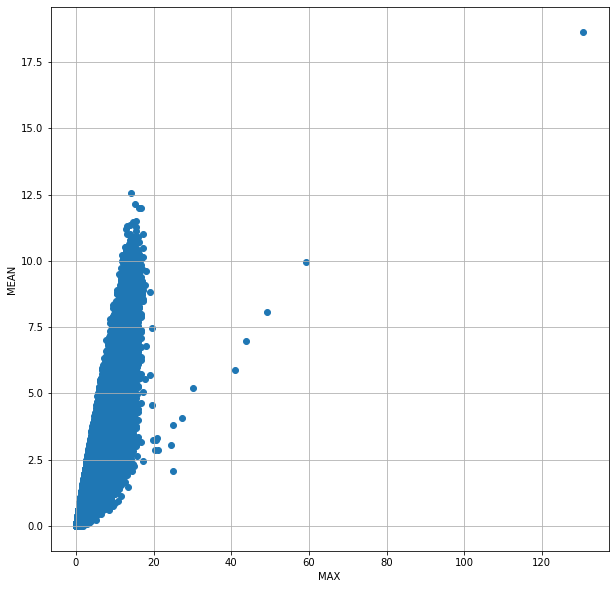

In [15]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10,10))
plt.grid('on')
plt.xlabel('MAX')
plt.ylabel('MEAN')
n = 700000
plt.scatter(target_vector[0,:n].flatten(), target_vector[1,:n].flatten())
plt.show()

In [16]:
# Always interesting to look at outlier regions
np.where((target_vector[0,:n]>40) & (target_vector[1,:n]>3))


(array([127620, 127620, 127620, 127620, 127620]), array([ 1,  5,  6, 10, 17]))

Not super interesting but I was interested in the amount of zero peaks

In [17]:
# Count zero values
tmp = target_vector[1].flatten()
count_zeros = tmp.size - np.count_nonzero(tmp)

print("Number of zero values:", count_zeros)

Number of zero values: 345910


Distribution of peak values

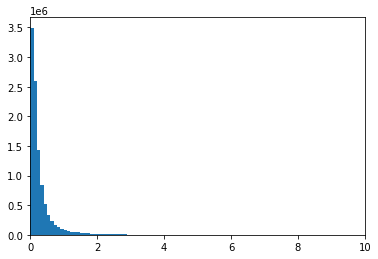

In [18]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
tmp = np.sort(target_vector[1].flatten())
#tmp = np.sort(tmp.flatten())
plt.hist(tmp, bins=100, range=(0, 10))
plt.xlim(0,10)
plt.show()

### Here the useful part starts, we divide the dataset based on chromosomal distribution

In [21]:
df['chrom'].value_counts()

chr2     43783
chr1     38414
chr11    36591
chr5     36262
chr4     36147
chr7     33126
chr9     31760
chr6     30455
chr8     28863
chr10    27201
chr3     26832
chr12    24455
chr13    24348
chr15    23979
chr17    22636
chr14    22189
chr16    19481
chr18    18176
chr19    14935
chrX      7360
Name: chrom, dtype: int64

Based on the above distribution, we choose chr8 and chr10 for validation and chr9, chr18 and chrX for testing (I aim for 80% training and 10% validation and test)

In [24]:
train_idcs = df.index[(df['chrom']!='chr8') & (df['chrom']!='chr10') & (df['chrom']!='chr9') & (df['chrom']!='chr18')].tolist() 
val_idcs = df.index[(df['chrom']=='chr8') | (df['chrom']=='chr10')].tolist() 
test_idcs = df.index[(df['chrom']=='chr9') | (df['chrom']=='chr18')].tolist() 

In [25]:
print('Nr of training samples: '+ str(len(train_idcs)))
print('Nr of validation samples: '+ str(len(val_idcs)))
print('Nr of testing samples: '+ str(len(test_idcs)))

Nr of training samples: 440993
Nr of validation samples: 56064
Nr of testing samples: 49936


In [26]:
X_train = seqs_one_hot[train_idcs]
X_val = seqs_one_hot[val_idcs]
X_test = seqs_one_hot[test_idcs]

ids_train = seqs_ids[train_idcs]
ids_val = seqs_ids[val_idcs]
ids_test = seqs_ids[test_idcs]

Y_train = target_vector[1,train_idcs]
Y_val = target_vector[1,val_idcs]
Y_test = target_vector[1,test_idcs]

In [28]:
nonAugmented_data_dict = {'train_data':X_train, 'valid_data':X_val, 'test_data':X_test, 'y_train':Y_train, 'y_valid':Y_val, 'y_test':Y_test, 'ids_train':ids_train, 'ids_test':ids_test, 'ids_valid':ids_val }

In [98]:
del seqs_one_hot

For now the augmented_data_dict is the same as nonAugmented.

In [152]:
import os
augmented_data_dict = nonAugmented_data_dict
f = open(os.path.join(out_path, 'augmented_data_dict.pkl'), "wb")
pickle.dump(augmented_data_dict, f)
f.close()
f = open(os.path.join(out_path, 'nonAugmented_data_dict.pkl'), "wb")
pickle.dump(nonAugmented_data_dict, f)
f.close()

# TL to DARs

This is still WIP but you can take a look. Here I make a new dictionary only containing peaks that are DAR-like.

In [119]:
import numpy as np
import numpy as np
from collections import Counter

target_values = target_vector[1]
classes = ['Astro', 'Endo', 'L2_3IT', 'L5ET', 'L5IT', 'L5_6NP', 'L6CT', 'L6IT', 'L6b', 'Lamp5','Micro_PVM', 'OPC', 'Oligo', 'Pvalb', 'Sncg','Sst', 'SstChodl', 'VLMC', 'Vip']
# Set your thresholds
first_second_ratio_threshold = 2
second_third_ratio_threshold = 1.5

# Initialize list to keep track of indices
selected_indices = []
first_second_ratios = []
second_third_ratios = []

# Initialize dictionary to keep track of highest peaks per class
highest_peaks_count = {}

# Iterate through target vectors
for i, values in enumerate(target_values):
    sorted_indices = np.argsort(values)[::-1]  # Sort values and get indices
    sorted_values = values[sorted_indices]
    
    # Calculate ratios
    first_second_ratio = sorted_values[0] / sorted_values[1]
    second_third_ratio = sorted_values[1] / sorted_values[2]
    
    # Check if ratios exceed the thresholds
    if first_second_ratio >= first_second_ratio_threshold or second_third_ratio >= second_third_ratio_threshold:
        selected_indices.append(i)
        first_second_ratios.append(first_second_ratio)
        second_third_ratios.append(second_third_ratio)
        
        # Update highest peaks count
        class_with_highest_peak = sorted_indices[0]
        highest_peaks_count[class_with_highest_peak] = highest_peaks_count.get(class_with_highest_peak, 0) + 1


# Translate highest peaks count to class names
highest_peaks_count_named = {classes[k]: v for k, v in highest_peaks_count.items()}

print("Selected indices out of "+str(len(target_values))+":"+str(len(selected_indices)))
print("Highest peaks count:", highest_peaks_count_named)

Selected indices out of 546993:166480
Highest peaks count: {'Sst': 3219, 'Lamp5': 5587, 'SstChodl': 10969, 'L5_6NP': 3714, 'Oligo': 22495, 'Pvalb': 3260, 'Sncg': 7124, 'L6CT': 2697, 'Vip': 3509, 'L5IT': 3648, 'Endo': 10735, 'Astro': 14845, 'OPC': 5385, 'L6b': 2684, 'L5ET': 5295, 'L2_3IT': 3731, 'L6IT': 1897, 'Micro_PVM': 39961, 'VLMC': 15725}


In [144]:
seqs_ids_TL = seqs_ids[selected_indices]
seqs_one_hot_TL = seqs_one_hot[selected_indices]
target_vector_TL = target_vector[:,selected_indices]

In [145]:
import pandas as pd

# Parsing the sequence IDs
chroms = []
starts = []
ends = []

for seq_id in seqs_ids_TL:
    chrom, pos_range = seq_id.split(":")
    start, end = map(int, pos_range.split("-"))
    
    chroms.append(chrom)
    starts.append(start)
    ends.append(end)

# Creating a DataFrame
df_TL = pd.DataFrame({
    'chrom': chroms,
    'start': starts,
    'end': ends,
    'first_second_ratio':first_second_ratios,
    'second_third_ratio':second_third_ratios
})

tgt_vals_df = pd.DataFrame(target_vector_TL[1])
tgt_vals_df.columns = classes
df_TL = pd.concat([df_TL, tgt_vals_df], axis=1)

df_TL


,chrom,start,end,first_second_ratio,second_third_ratio,Astro,Endo,L2_3IT,L5ET,L5IT,L5_6NP,L6CT,L6IT,L6b,Lamp5,Micro_PVM,OPC,Oligo,Pvalb,Sncg,Sst,SstChodl,VLMC,Vip
0,chr1,3093998,3096112,1.019670,1.564435,0.042526,0.054660,0.290148,0.218616,0.423911,0.033864,0.407175,0.131653,0.027403,0.227561,0.024907,0.080099,0.014339,0.913519,0.139970,1.457253,1.429142,0.000000,0.555651
1,chr1,3111367,3113481,2.858399,1.101499,0.008075,0.088480,0.027962,0.025928,0.032476,0.073776,0.074001,0.037708,0.057683,0.453168,0.021415,0.000000,0.025952,0.065012,0.143930,0.053278,0.158539,0.136891,0.101163
2,chr1,3112727,3114841,2.419721,1.253353,0.002508,0.054294,0.048080,0.144867,0.059741,0.102076,0.163429,0.159691,0.204834,0.495642,0.000000,0.000000,0.019634,0.060252,0.044246,0.106440,0.000000,0.045922,0.073112
3,chr1,3164901,3167015,3.414476,1.080404,0.011852,0.031626,0.040151,0.013942,0.037994,0.023372,0.059441,0.067121,0.086656,0.159483,0.008595,0.000000,0.026926,0.077872,0.000000,0.172306,0.588335,0.100581,0.034252
4,chr1,3210016,3212130,1.269733,1.947879,0.010449,0.114622,0.107373,0.245767,0.104891,0.065975,0.136799,0.155443,0.197510,0.721174,0.000000,0.084785,0.040693,0.257041,0.567973,0.175928,0.000000,0.041067,0.291586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166475,chrX,169824148,169826262,2.181204,1.117269,0.058572,0.000000,0.097883,0.027151,0.109362,0.024340,0.012766,0.021382,0.000000,0.023674,0.037068,0.238541,0.019038,0.029771,0.001205,0.011175,0.000000,0.000000,0.035644
166476,chrX,169837427,169839541,5.455506,1.047035,1.887731,0.000000,0.049588,0.039993,0.026027,0.025035,0.025624,0.011935,0.047742,0.189861,0.012063,0.346023,0.057041,0.112347,0.319883,0.109364,0.220855,0.118833,0.330479
166477,chrX,169843232,169845346,2.608627,1.943228,0.203898,0.000000,0.022064,0.004464,0.019033,0.033441,0.015098,0.023608,0.024852,0.040223,0.033747,0.000000,0.029811,0.022227,0.078163,0.006953,0.000000,0.015437,0.024172
166478,chrX,169879374,169881488,1.306447,1.959942,0.420708,0.830870,0.252343,0.111662,0.278722,0.165663,0.202027,0.339449,0.345315,0.228773,0.300887,0.423926,0.193288,0.266561,0.300084,0.219193,1.085488,0.302422,0.265657


In [140]:
#df_TL.sort_values(by='second_third_ratio', inplace=True, ascending=False)
#pd.set_option('display.max_columns', None)
#df_TL.head(50)

In [146]:
df_TL['chrom'].value_counts()

chr2     13026
chr1     12248
chr4     10939
chr5     10359
chr11    10308
chr7      9812
chr9      9384
chr6      9191
chr3      9189
chr8      8685
chr10     8626
chr13     7823
chr12     7211
chr14     7178
chr15     6747
chr17     6737
chr16     6115
chr18     5525
chr19     4740
chrX      2637
Name: chrom, dtype: int64

In [147]:
df_ = df_TL
train_idcs_TL = df_.index[(df_['chrom']!='chr8') & (df_['chrom']!='chr10') & (df_['chrom']!='chr9') & (df_['chrom']!='chr18')].tolist() 
val_idcs_TL = df_.index[(df_['chrom']=='chr8') | (df_['chrom']=='chr10')].tolist() 
test_idcs_TL = df_.index[(df_['chrom']=='chr9') | (df_['chrom']=='chr18')].tolist() 
print('Nr of training samples: '+ str(len(train_idcs_TL)))
print('Nr of validation samples: '+ str(len(val_idcs_TL)))
print('Nr of testing samples: '+ str(len(test_idcs_TL)))
X_train = seqs_one_hot_TL[train_idcs_TL]
X_val = seqs_one_hot_TL[val_idcs_TL]
X_test = seqs_one_hot_TL[test_idcs_TL]

ids_train = seqs_ids_TL[train_idcs_TL]
ids_val = seqs_ids_TL[val_idcs_TL]
ids_test = seqs_ids_TL[test_idcs_TL]

Y_train = target_vector_TL[1,train_idcs_TL]
Y_val = target_vector_TL[1,val_idcs_TL]
Y_test = target_vector_TL[1,test_idcs_TL]
nonAugmented_data_dict_TL = {'train_data':X_train, 'valid_data':X_val, 'test_data':X_test, 'y_train':Y_train, 'y_valid':Y_val, 'y_test':Y_test, 'ids_train':ids_train, 'ids_test':ids_test, 'ids_valid':ids_val }

Nr of training samples: 134260
Nr of validation samples: 17311
Nr of testing samples: 14909


In [151]:
import os
augmented_data_dict_TL = nonAugmented_data_dict_TL
out_path_TL = out_path+'TL/'
f = open(os.path.join(out_path_TL, 'augmented_data_dict.pkl'), "wb")
pickle.dump(augmented_data_dict_TL, f)
f.close()
f = open(os.path.join(out_path_TL, 'nonAugmented_data_dict.pkl'), "wb")
pickle.dump(nonAugmented_data_dict_TL, f)
f.close()

In [9]:
import os
out_path_TL = '/staging/leuven/stg_00002/lcb/lcb_projects/biccn_okt_2023/analysis/deeppeak/mouse/data/2114/TL/'

nonAugmented_dir = out_path_TL

f = open(os.path.join(nonAugmented_dir, 'augmented_data_dict.pkl'), "rb")

nonAugmented_data_dict_TL = pickle.load(f)
f.close()


# Model evaluation

Load augmented data dictionary and models

In [19]:
import os
out_path = '/staging/leuven/stg_00002/lcb/lcb_projects/biccn_okt_2023/analysis/deeppeak/mouse/data/2114/'
out_path_TL = '/staging/leuven/stg_00002/lcb/lcb_projects/biccn_okt_2023/analysis/deeppeak/mouse/data/2114/TL/'

nonAugmented_dir = out_path_TL

print('Loading data...')
f = open(os.path.join(nonAugmented_dir, 'nonAugmented_data_dict.pkl'), "rb")

nonAugmented_data_dict_TL = pickle.load(f)
f.close()


Loading data...


In [21]:
import utils
import os 
import shap
model_dict = {}
exp_dict = {} 
nonAugmented_data_dict = nonAugmented_data_dict_TL
rn=np.random.choice(nonAugmented_data_dict["valid_data"].shape[0], 350, replace=False)

out_path = '/staging/leuven/stg_00002/lcb/lcb_projects/biccn_okt_2023/analysis/deeppeak/mouse/data/2114/'

name="custom"
output_dir = out_path+'cbpnet_custom_mse'
selected_model = 'model_epoch_26.hdf5'
model_custom = utils.load_model(output_dir, selected_model)
model_dict[name] = model_custom
exp_dict[name] = shap.DeepExplainer((model_dict[name].inputs, model_dict[name].layers[-1].output), nonAugmented_data_dict["valid_data"][rn])

name="custom_TL"
output_dir = out_path_TL+'cbpnet_custom_TL_ft'
selected_model = 'model_epoch_12.hdf5'
model_custom_TL = utils.load_model(output_dir, selected_model)
model_dict[name] = model_custom_TL
exp_dict[name] = shap.DeepExplainer((model_dict[name].inputs, model_dict[name].layers[-1].output), nonAugmented_data_dict["valid_data"][rn])


Predict on test set and show indices of highest predicted regions for a cell type

In [23]:
preds = model_custom.predict(nonAugmented_data_dict["test_data"])
np.flip(np.argsort(preds[:, 13]))[0:10]

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


array([ 8953, 13222,  6206, 12395, 11291,   947, 10406, 13287, 13834,
        1968])

In [24]:
classes = ['Astro', 'Endo', 'L2_3IT', 'L5ET', 'L5IT', 'L5_6NP', 'L6CT', 'L6IT', 'L6b', 'Lamp5','Micro_PVM', 'OPC', 'Oligo', 'Pvalb', 'Sncg','Sst', 'SstChodl', 'VLMC', 'Vip']

Show some example predictions

['chr18:4506268-4508382']
[[0.0609008  0.4305167  0.6263509  0.84621056 0.69909002 0.12212285
  1.31326187 1.28743881 0.72005964 0.09066321 0.04278149 0.00834673
  0.04606105 0.06207503 0.07058777 0.10537459 0.0274923  0.16417209
  0.1038156 ]]
6


`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


<Figure size 5760x360 with 0 Axes>

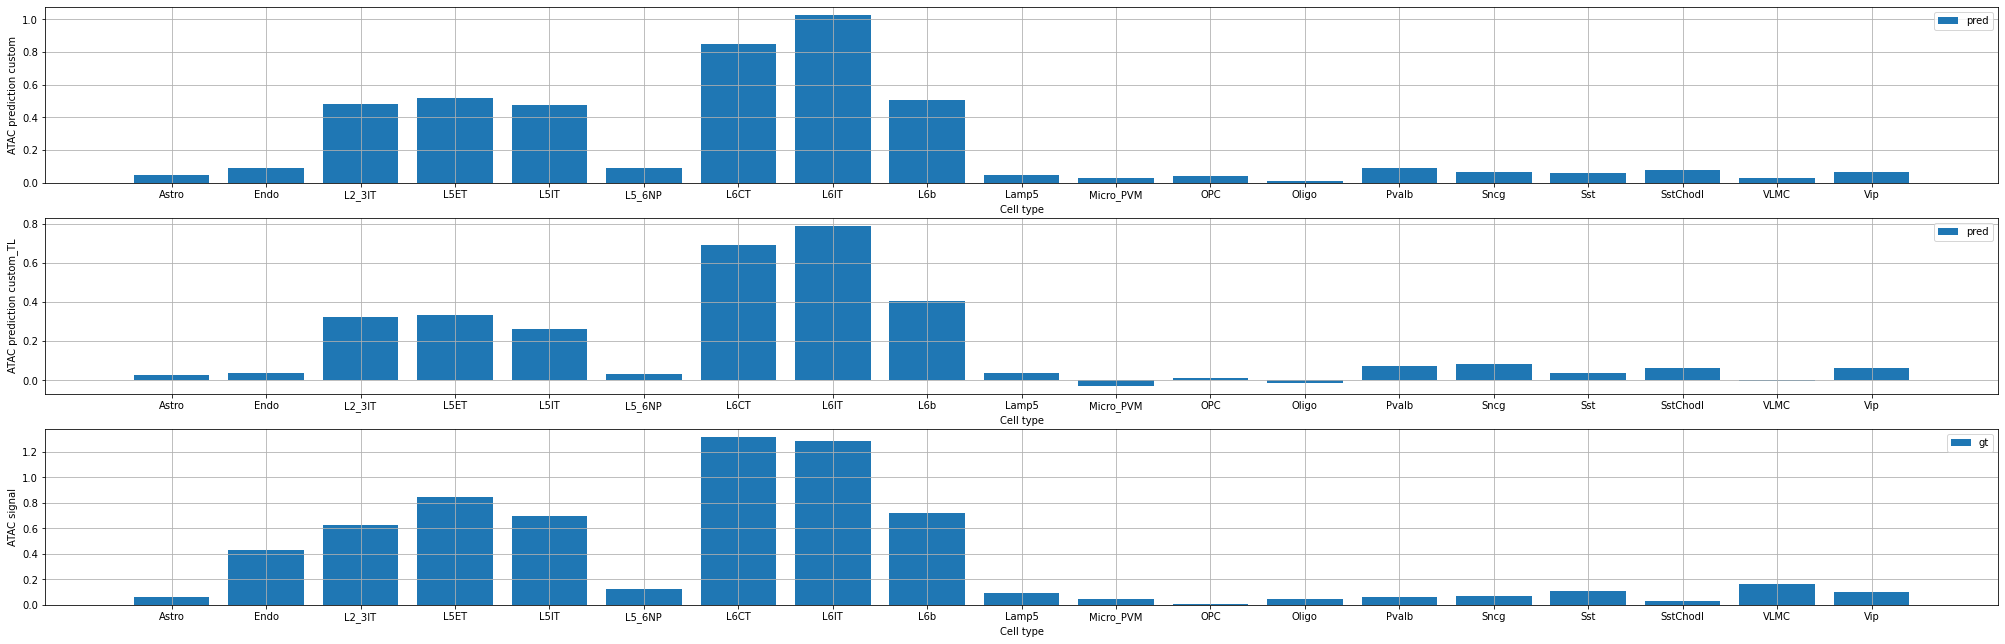

In [25]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
index = 61#11251 # Here just a random index from your test set

#model  = model_mse
seq_onehot=nonAugmented_data_dict["test_data"][index:index+1]
print(nonAugmented_data_dict["ids_test"][index:index+1])
print(nonAugmented_data_dict["y_test"][index:index+1])
print(np.argmax(nonAugmented_data_dict["y_test"][index:index+1]))
#Prediction on a given region
ntrack = 1
fig = plt.figure(figsize=(80,ntrack*5))
track_no=1

ntrack = len(model_dict.keys())
fig = plt.figure(figsize=(35,5*ntrack+1))
for i, model in enumerate(model_dict):
    plt.subplot(ntrack+1,1,i+1)
    plt.bar(classes, model_dict[model].predict(seq_onehot)[0], label='pred')
    plt.legend()
    plt.xlabel('Cell type')
    plt.ylabel('ATAC prediction '+model)
    plt.grid('on')
#plt.show()


plt.subplot(ntrack+1,1,ntrack+1)
plt.bar(classes,nonAugmented_data_dict["y_test"][index:index+1][0], label='gt')
plt.legend()
plt.xlabel('Cell type')
plt.ylabel('ATAC signal')
plt.grid('on')
plt.show()

If you want to find the index of a certain region

In [26]:
(df.loc[(df["chrom"] =='chr18') & (df["start"] > 61106000) & (df["end"] < 61110000)])

,chrom,start,end,name
250544,chr18,61106697,61108811,chr18:61106697-61108811
250545,chr18,61107570,61109684,chr18:61107570-61109684


In [27]:
fire_idx = np.where(nonAugmented_data_dict["ids_test"] == "chr18:61107570-61109684")
fire_idx

(array([3445]),)

In [29]:
tmp_idx = np.where(nonAugmented_data_dict["ids_test"] == 'chr18:4506268-4508382')
tmp_idx

(array([61]),)

If you have multiple models, this gives a summarixing list of prediction performance on the test set with several metrics

In [32]:
from tqdm import tqdm
preds = np.zeros((len(model_dict.keys()), len(nonAugmented_data_dict_TL["test_data"]),len(classes)))
for i, model in tqdm(enumerate(model_dict), total=len(model_dict)):
    preds[i] = model_dict[model].predict(nonAugmented_data_dict_TL["test_data"])

100%|██████████| 2/2 [00:44<00:00, 22.17s/it]


In [33]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy import spatial, stats
import pandas as pd
import numpy as np

# Initialize dictionary to hold metrics for each prediction set
metrics_dict = {}

# Initialize DataFrame to hold average metrics for each prediction set
avg_metrics_df = pd.DataFrame(columns=['Prediction_Set', 'Avg_MAE', 'Avg_MSE', 'Avg_Pearson', 'Avg_Spearman'])

# Your list of multiple prediction sets. Replace with your actual data.
multiple_prediction_sets = preds  # e.g., preds1, preds2 are your sets of predicted values
ground_truth = nonAugmented_data_dict_TL["y_test"]

for prediction_set_index, predictions in enumerate(multiple_prediction_sets):
    # Initialize the output array for this prediction set
    output = np.zeros((4, len(ground_truth.T)))  # 4 metrics: MSE, MAE, Pearson, Spearman
    
    # Iterate over each cell type
    for i, (pred_col, gt_col) in enumerate(zip(predictions.T, ground_truth.T)):
        # Filter out negative or NaN values in ground truth
        valid_indices = np.where(gt_col >= 0)[0]
        
        pred_values = pred_col[valid_indices]
        gt_values = gt_col[valid_indices]
        
        # Compute MAE
        output[0, i] = mean_absolute_error(gt_values, pred_values)
        
        # Compute MSE
        output[1, i] = mean_squared_error(gt_values, pred_values)
        
        # Compute Pearson Correlation
        pearson_corr = np.corrcoef(pred_values, gt_values)[0, 1]
        output[2, i] = pearson_corr if not np.isnan(pearson_corr) else 0
        
        # Compute Spearman Correlation
        spearman_corr, _ = stats.spearmanr(pred_values, gt_values)
        output[3, i] = spearman_corr if not np.isnan(spearman_corr) else 0
    
    # Save the output array for this prediction set into the metrics dictionary
    metrics_dict[list(model_dict.keys())[prediction_set_index]] = output
    
    # Calculate average metrics for this prediction set and store in DataFrame
    avg_metrics = np.mean(output, axis=1)
    avg_metrics_df.loc[prediction_set_index] = [list(model_dict.keys())[prediction_set_index], *avg_metrics]

print(avg_metrics_df)

    

  Prediction_Set   Avg_MAE   Avg_MSE  Avg_Pearson  Avg_Spearman
0         custom  0.119334  0.061949     0.641885      0.597221
1      custom_TL  0.110357  0.056002     0.662063      0.596729


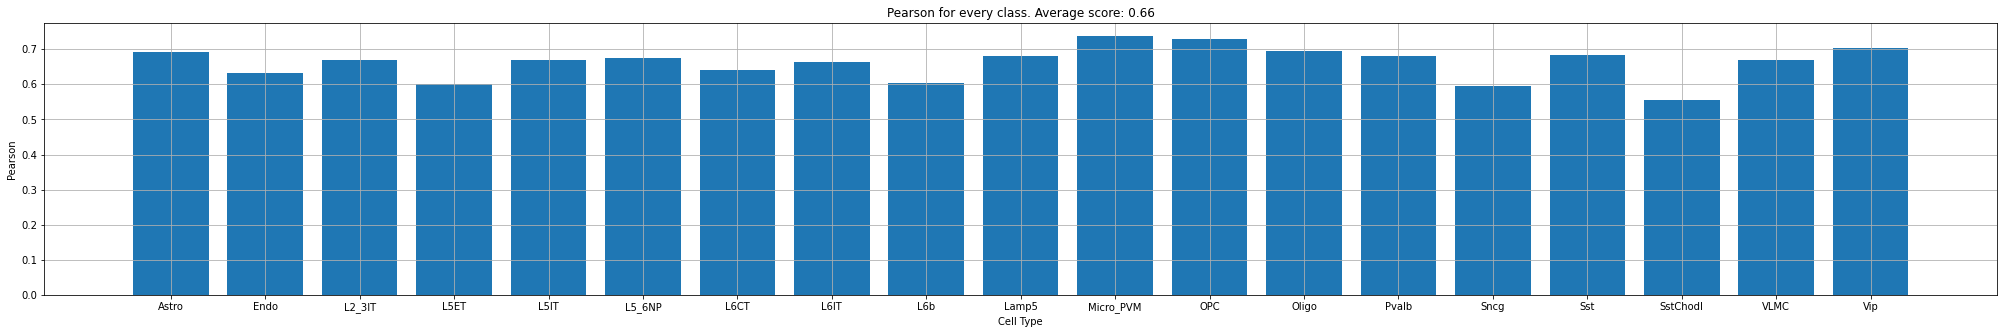

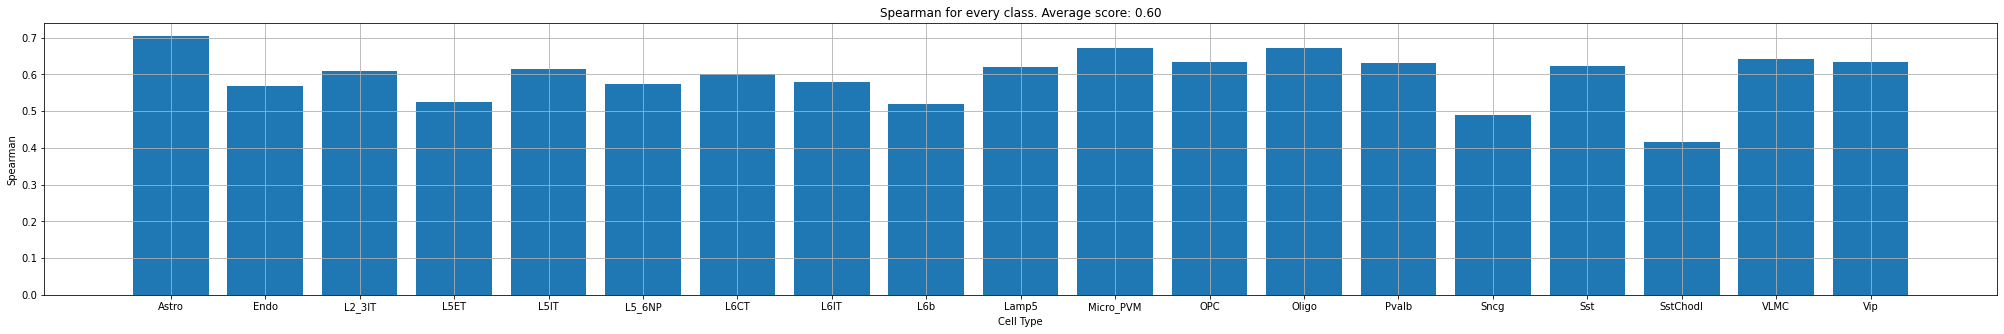

In [37]:
import matplotlib.pyplot as plt

# Function to plot metrics
def plot_metrics(metrics_array, metric_name, cell_types):
    plt.figure(figsize=(35,5))
    plt.bar(cell_types, metrics_array)
    plt.title(f'{metric_name} for every class. Average score: {np.mean(metrics_array):.2f}')
    plt.ylabel(metric_name)
    plt.xlabel('Cell Type')
    plt.grid(True)
    plt.show()

# Assuming cell_types is a list of cell type names
cell_types = classes  

# Choose a specific prediction set from metrics_dict
prediction_set_key = 'custom_TL'  # Replace this with the actual key corresponding to the prediction set you are interested in

# Extract the metrics for this prediction set
metrics_array = metrics_dict[prediction_set_key]

# Plot each metric
#plot_metrics(metrics_array[0], 'MAE', cell_types)
#plot_metrics(metrics_array[1], 'MSE', cell_types)
plot_metrics(metrics_array[2], 'Pearson', cell_types)
plot_metrics(metrics_array[3], 'Spearman', cell_types)


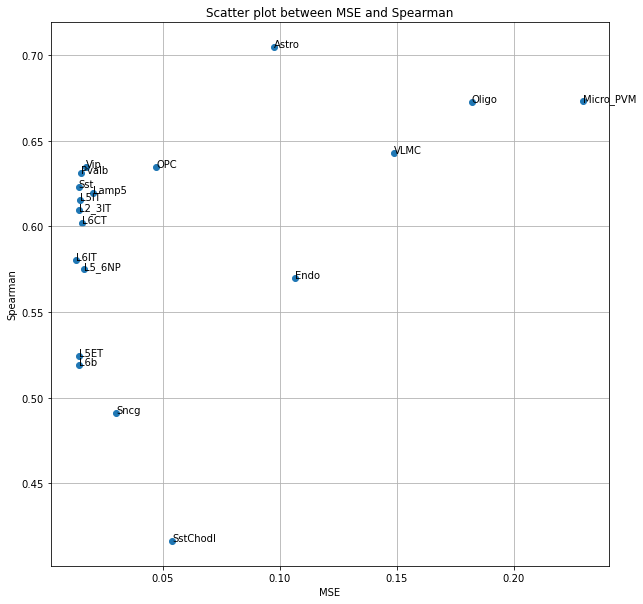

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data for demonstration
# Replace this with your actual metrics
output = metrics_dict['custom_TL']

# List of metric names, in the order they appear in 'output'
metric_names = ['MAE', 'MSE', 'Pearson', 'Spearman']

# Function to create scatter plot for two metrics
def plot_scatter(metric1, metric2, metric1_name, metric2_name, classes):
    plt.figure(figsize=(10,10))
    plt.scatter(metric1, metric2)
    plt.xlabel(metric1_name)
    plt.ylabel(metric2_name)
    plt.title(f'Scatter plot between {metric1_name} and {metric2_name}')
    plt.grid(True)
    
    for i, class_ in enumerate(classes):
        plt.text(metric1[i], metric2[i], class_)
    
    plt.show()

# Select two metrics by their row index in 'output'
metric1_index = 1  # Replace with the index for your first chosen metric
metric2_index = 3  # Replace with the index for your second chosen metric

# Extract these metrics
metric1 = output[metric1_index]
metric2 = output[metric2_index]

# Automatically set their names for labeling
metric1_name = metric_names[metric1_index]
metric2_name = metric_names[metric2_index]

# Create the scatter plot
plot_scatter(metric1, metric2, metric1_name, metric2_name, classes)


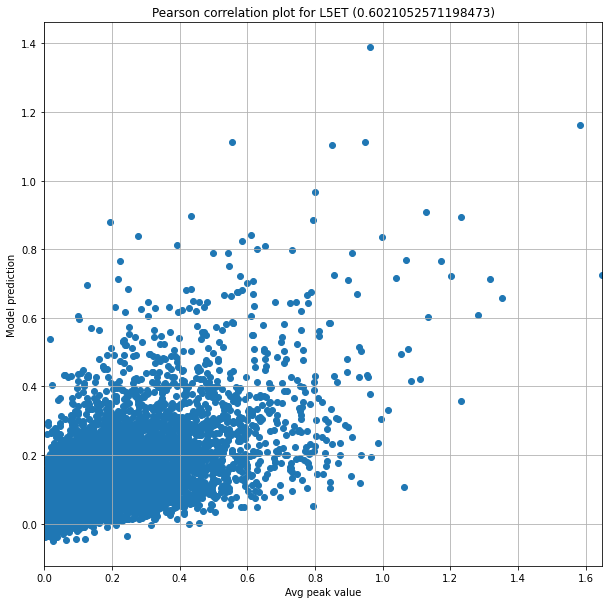

In [42]:
from scipy.stats import gaussian_kde

idx=3 # cell type
prediction_set = 1 # model
x=ground_truth[:,idx][np.where(ground_truth[:,idx]>=0)]
y= preds[prediction_set,:,idx][np.where(ground_truth[:,idx]>=0)]

#xy = np.vstack([x,y])
#z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
#idcs = z.argsort()

#x, y, z = x[idcs], y[idcs], z[idcs]
plt.figure(figsize=(10,10))
plt.scatter(x, y)#,c=z, s=50)
plt.grid('on')
plt.ylabel('Model prediction')
plt.xlabel('Avg peak value')
plt.xlim([0,np.max(x)])
plt.title('Pearson correlation plot for '+classes[idx]+ ' ('+str(output[2,idx])+')')
plt.show()

Check outliers

In [44]:
np.where((ground_truth[:,idx]>1.5) & (preds[prediction_set,:,idx]>1))
#np.where(preds[:,idx]>6)

(array([13222]),)

In [45]:
nonAugmented_data_dict_TL["ids_test"][13222]

'chr9:106684892-106687006'

# DeepExplainer

Define your region of interest

In [47]:
from pybedtools import BedTool
import utils
location = ("chr18", 61108475, 61108975) # FIRE enhancer

location_ext = (location[0], location[1]-807, location[2]+807) # extend 500 bp peaks to 2114 if needed
location_ext = ('chr18',4421019,4423133)
#location = (location_ext[0], location_ext[1]+807, location_ext[2]-807)

genomefile_path = "/staging/leuven/res_00001/genomes/mus_musculus/mm10_ucsc/fasta/mm10.fa"

seq_onehot = utils.one_hot_encode_along_row_axis(BedTool.seq(location, genomefile_path))
seq_onehot_ext = utils.one_hot_encode_along_row_axis(BedTool.seq(location_ext, genomefile_path))

In [48]:
%load_ext autoreload
%autoreload 2

DeepExplainer for different models on the same topic

100%|██████████| 2/2 [01:03<00:00, 31.73s/it]


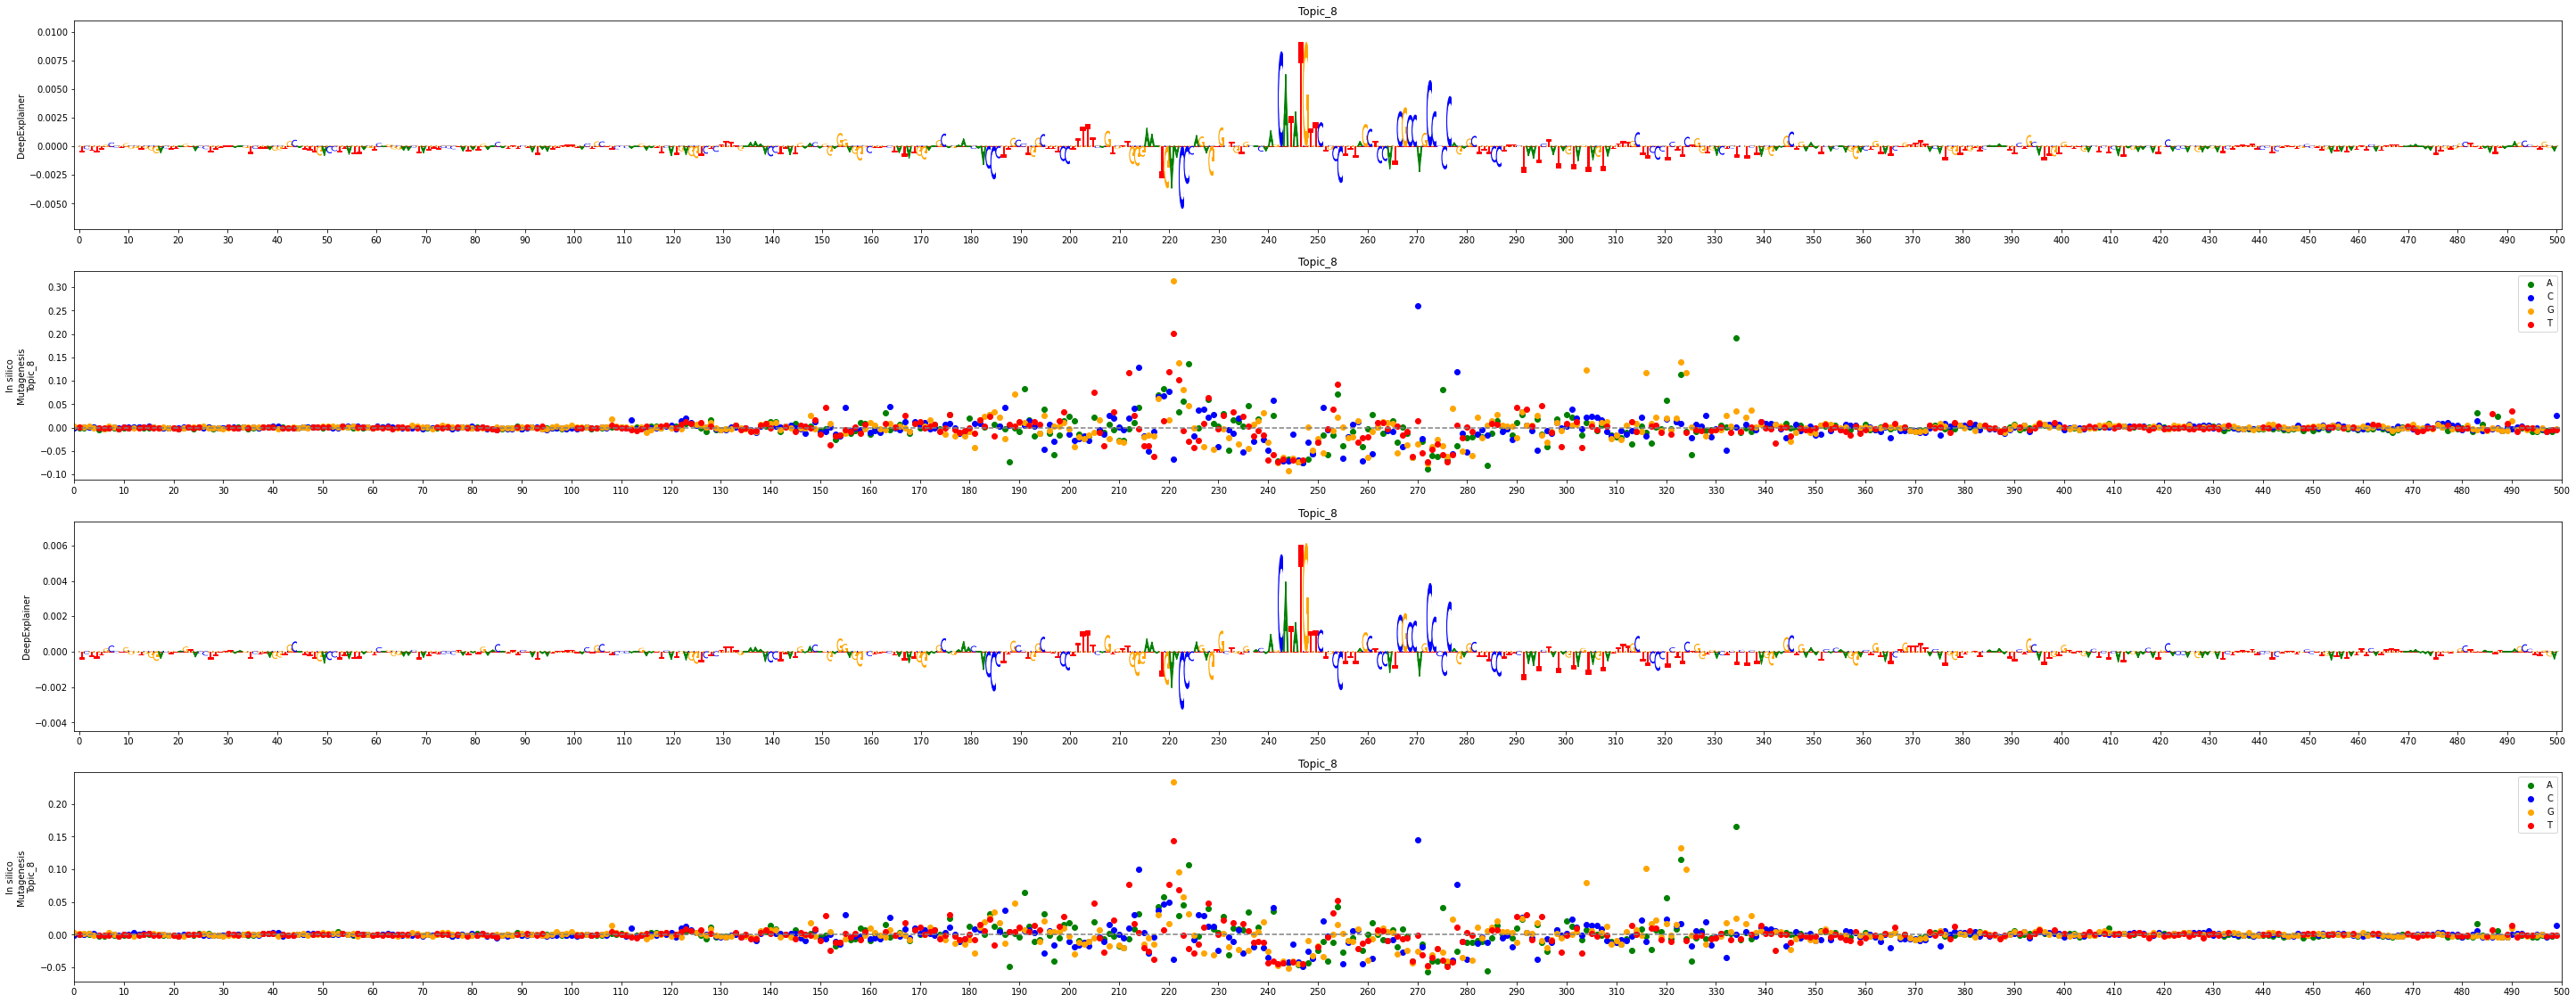

In [50]:
from tqdm import tqdm
zoom=500 # The regions are 2114 bp so you can also look on that scale
topic=8

# Plot deepexplainer for the selected topics

models = model_dict.keys()
n_track=len(models)*2+1
fig = plt.figure(figsize=(50,n_track*5))
for i, model in tqdm(enumerate(models),total=len(models)):
    track_no=2*i+1
    ax1 = utils.plot_deepexplainer_givenax(explainer=exp_dict[model], fig=fig, ntrack=n_track, track_no=track_no, seq_onehot=seq_onehot_ext, topic = topic, zoom=zoom)
    track_no=2*i+2
    ax1 = utils.plot_mutagenesis_givenax(model_dict[model], fig=fig, ntrack=n_track, track_no=track_no, seq_onehot=seq_onehot_ext, topic=topic, zoom=zoom)


DeepExplainer for the same region over different topics in one model

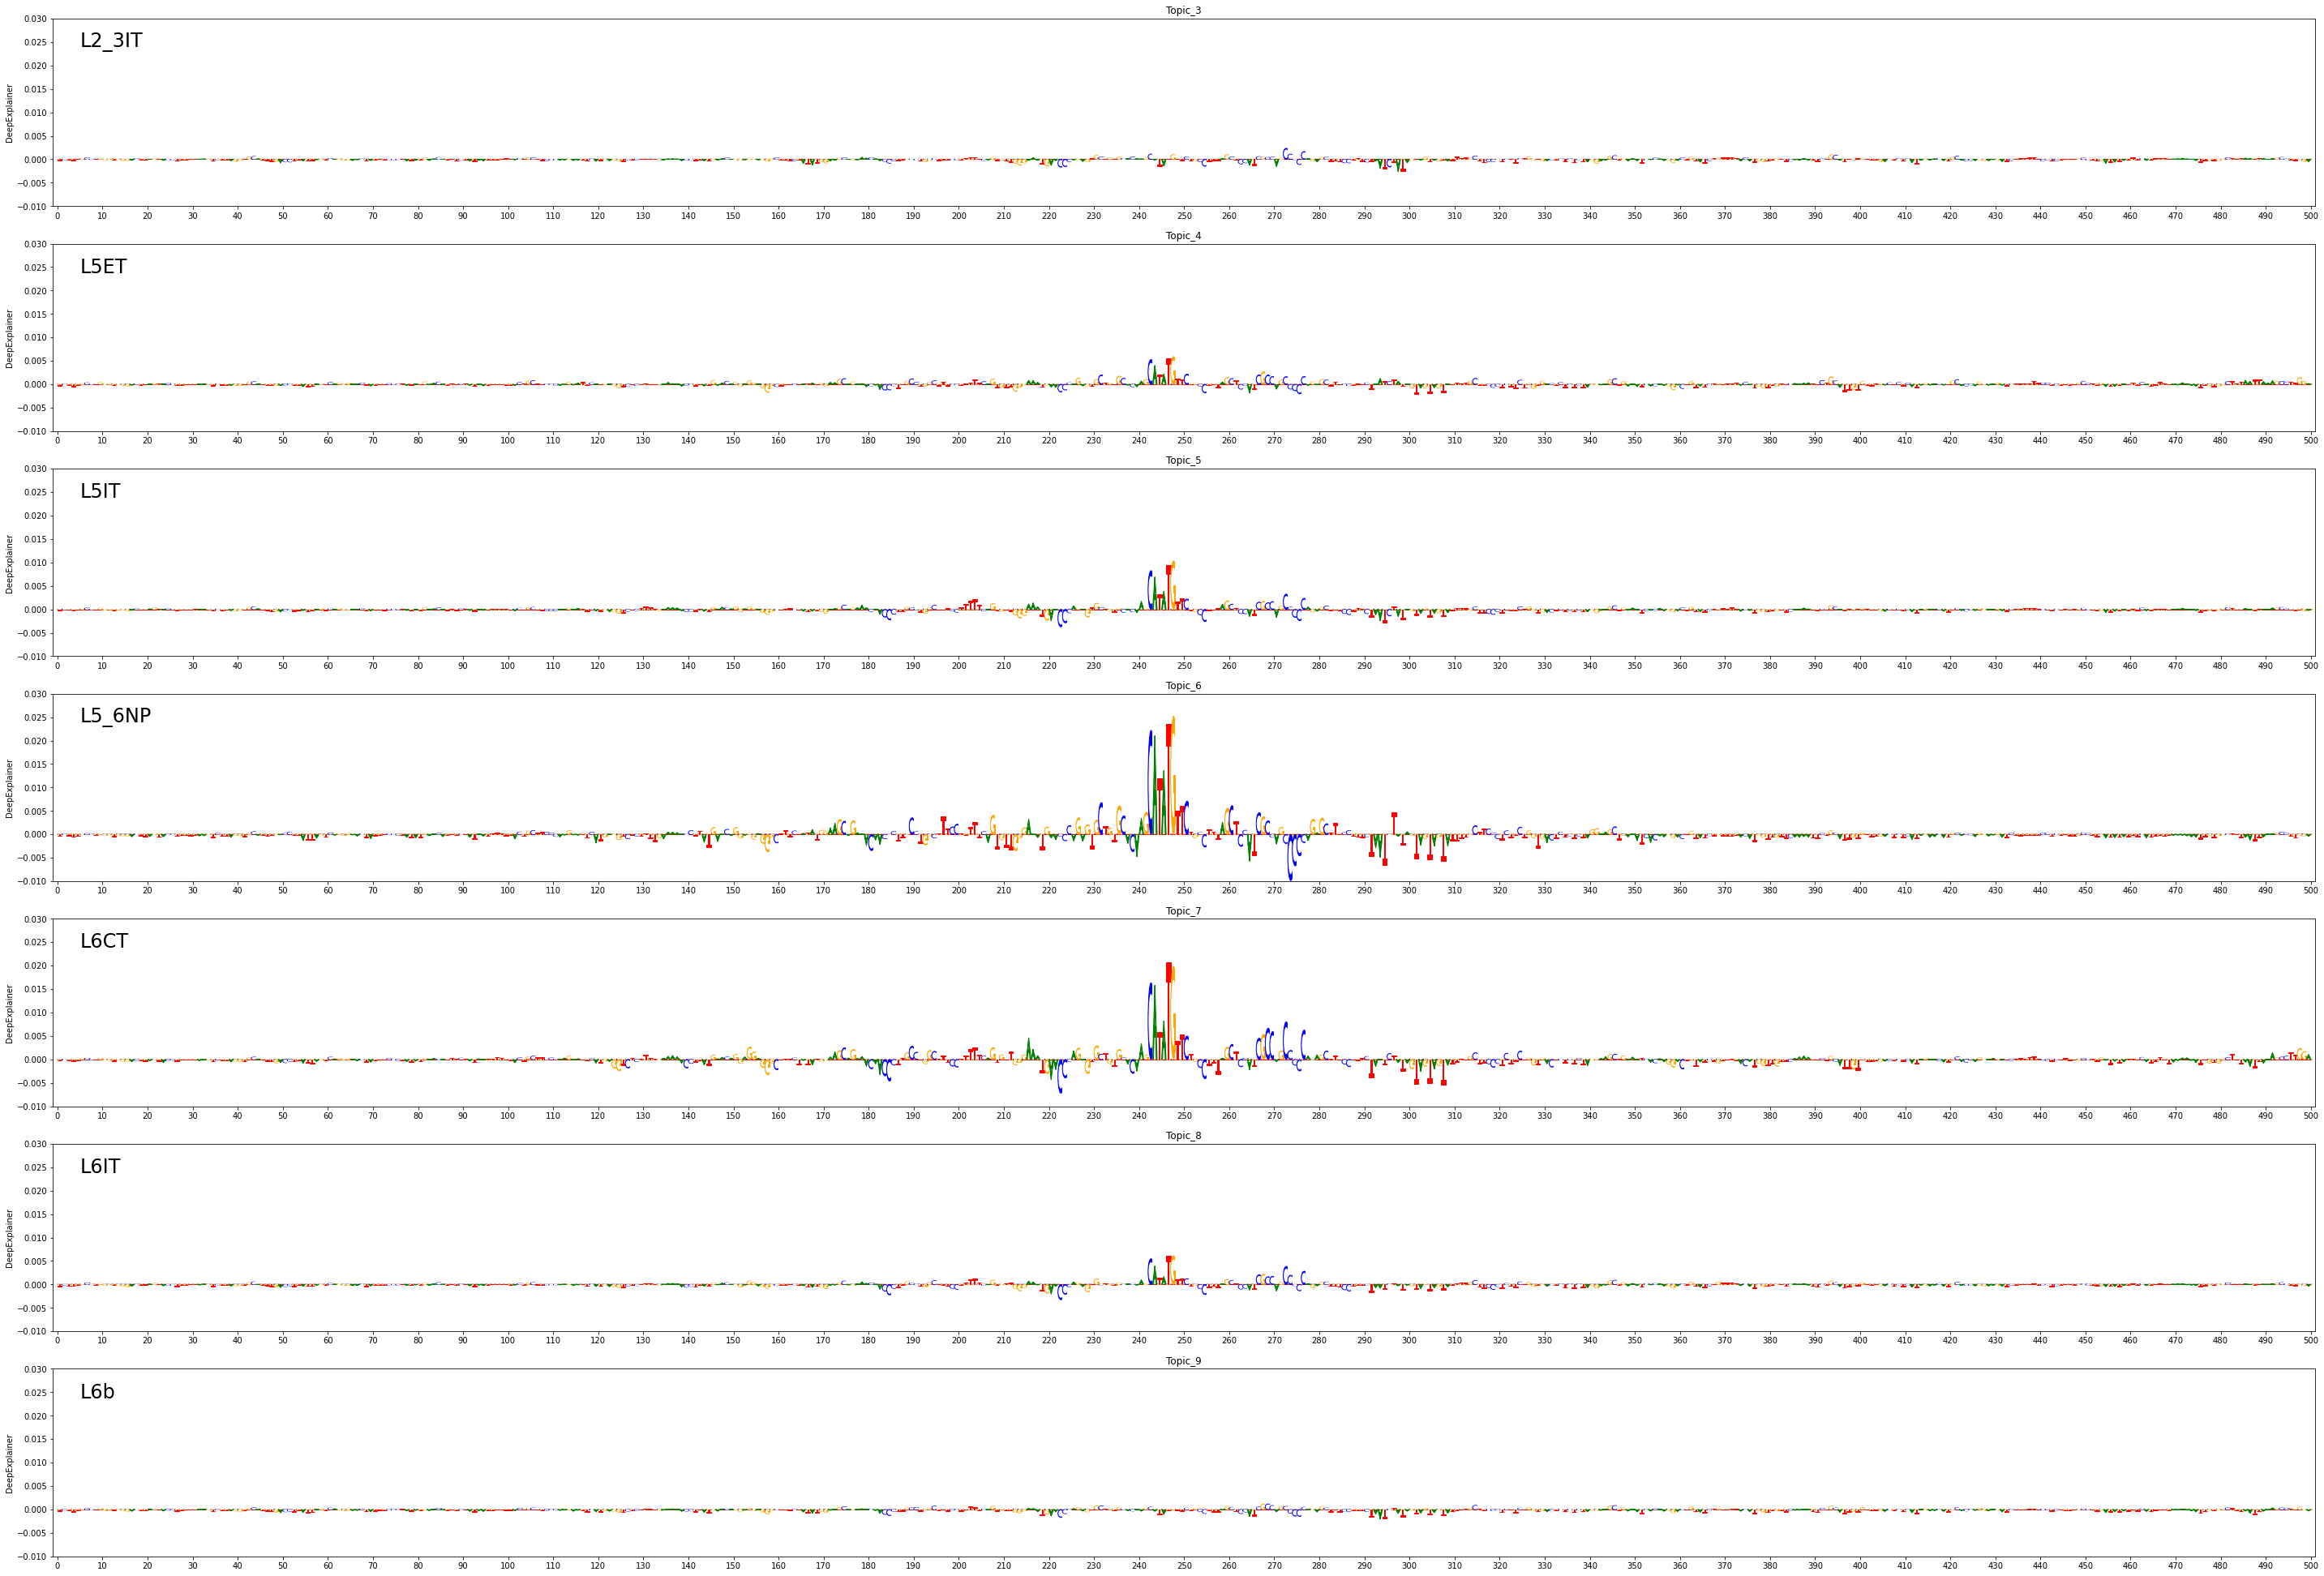

In [52]:
def plot_tracks(topics, seq_onehot, model_name, classes=classes, zoom=500,y_lim_min=-0.01, y_lim_max=0.03):
    seq_onehot_ext=seq_onehot
    n_track=len(topics)+1
    fig = plt.figure(figsize=(50,n_track*5))
    for i, topic in (enumerate(topics)):
        track_no=i+1
        #if(i in [21]):
        ax1 = utils.plot_deepexplainer_givenax(explainer=exp_dict[model_name], fig=fig, ntrack=n_track, track_no=track_no, seq_onehot=seq_onehot_ext, topic = topic, zoom=zoom)
        ax1.set_ylim([y_lim_min,y_lim_max])
        # Add text to the plot at a specific location
        x_pos = 5  # Adjust this value to set the x-coordinate where you want the text
        y_pos = 0.025  # Adjust this value to set the y-coordinate where you want the text
        text_to_add = classes[topics[i]-1]  # Replace with the text you want to add
        ax1.text(x_pos, y_pos, text_to_add, fontsize=24, ha='left', va='center')
    plt.show()

#topics = [3,4,5,6,7,8,9]
#topics = [10,14,15,16,17,19]
topics=[1,2,11,12,13]
plot_tracks(topics, seq_onehot, 'custom_TL')

In [47]:
def plot_bigwig(location, topics, len_=2114):
    gt = np.zeros((len(classes), len_))
    for i,bw in enumerate(bw_list):
        gt[i] = np.nan_to_num(np.array(bw.values(location[0],location[1],location[2])))
    max_peak = np.max(gt)
    plt.figure(figsize=(40,3*len(topics)))
    for i, topic in enumerate(topics):
        plt.subplot(len(topics),1,i+1)
        plt.bar(np.arange(location[1],location[2]),gt[topic-1])
        plt.xticks(np.arange(location[1],location[2], 50))
        plt.ylim([0,max_peak])

Predictions for that region for all models

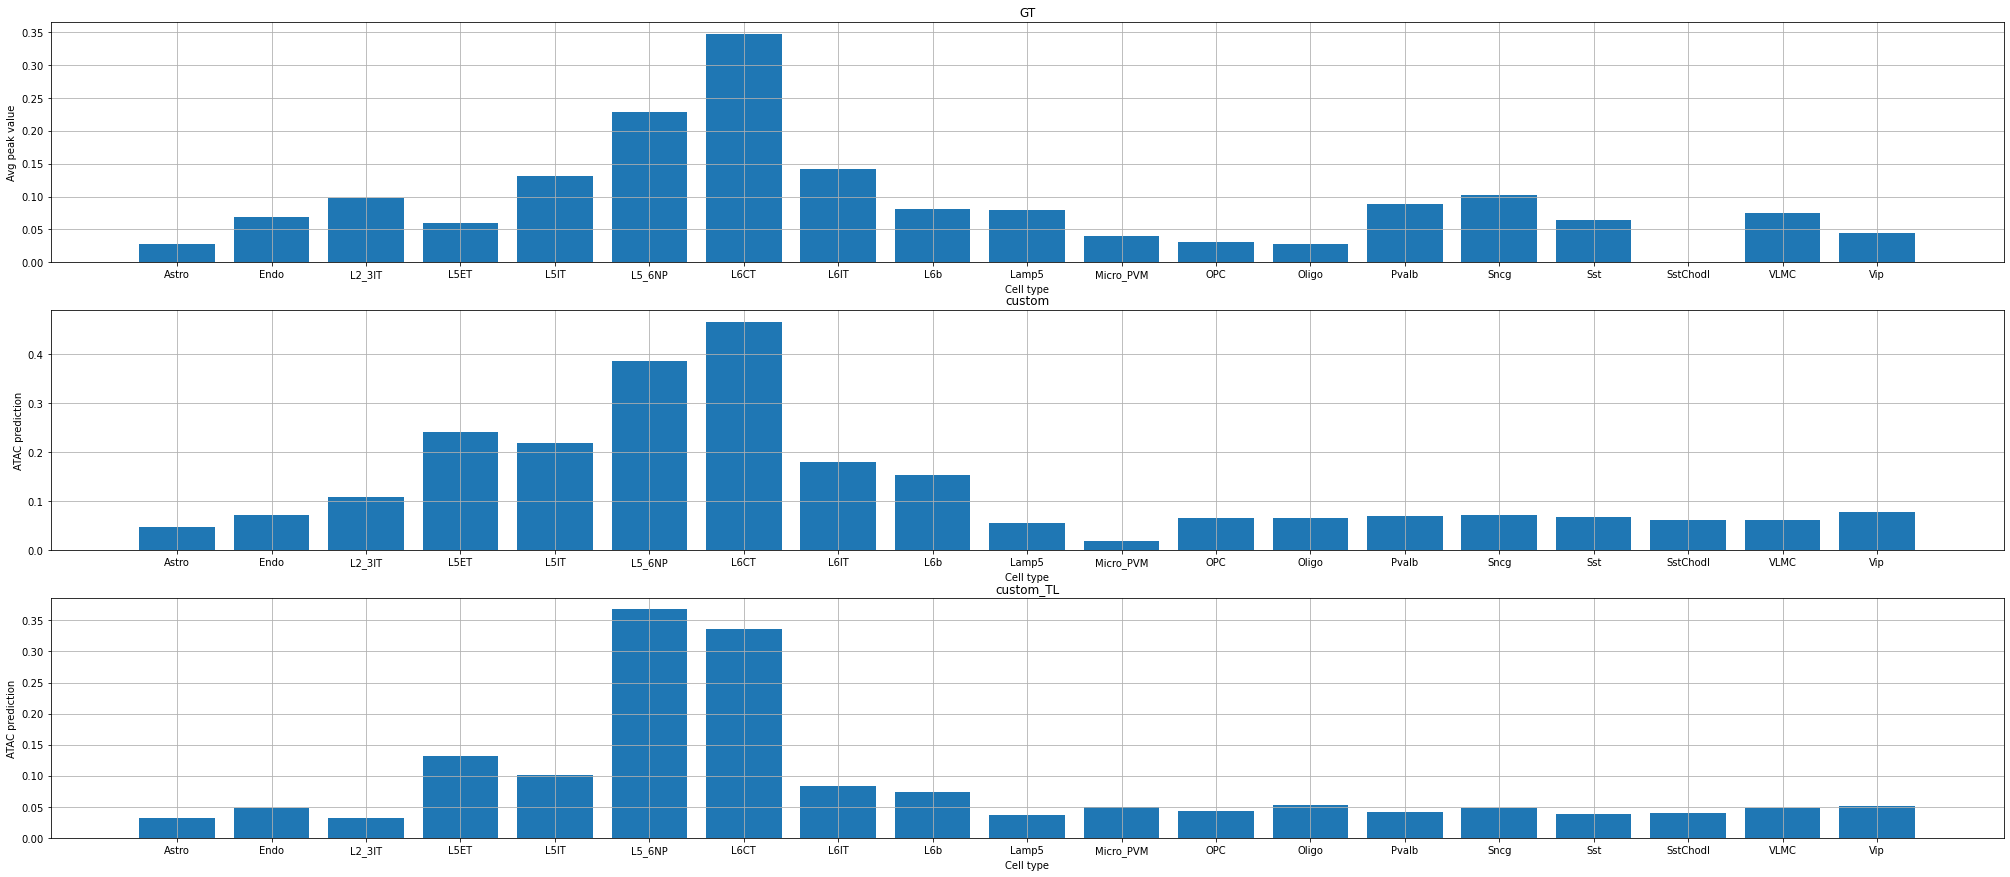

In [55]:
n_plots = len(model_dict)+1
fig = plt.figure(figsize=(35,5*n_plots))
gt = np.zeros(len(classes))
for i,bw in enumerate(bw_list):
    gt[i] = np.mean(np.nan_to_num(np.array(bw.values(location_ext[0],location_ext[1]+557,location_ext[2]-557))))
plt.subplot(n_plots,1,1)
plt.bar(classes, gt)
plt.title('GT')
plt.xlabel('Cell type')
plt.ylabel('Avg peak value')
plt.grid('on')

for i, model in enumerate(models):
    plt.subplot(n_plots,1,i+2)
    plt.bar(classes, model_dict[model].predict(seq_onehot_ext)[0])
    plt.title(model)
    plt.xlabel('Cell type')
    plt.ylabel('ATAC prediction')
    plt.grid('on')


# Calculating DARs - Niklas style

A way of finding high regions sorted on their difference with the second highest peaks

### General DAR calculation

In [56]:
def get_DARs_per_ct(target, target_vec, seq_ids, threshold=0):
    #get the peaks for which the highest peak corresponds to the target
    max_peaks = target_vec[np.array(np.where(np.argmax(target_vec, axis=1)==target))][0]
    seq_ids_peaks = seq_ids[np.array(np.where(np.argmax(target_vec, axis=1)==target))][0]
    
    #for every peak, sort the max peak values for all celltypes, and calculate the ratio between the highest peak (from the target) and the second highest
    sorted_peaks = np.flip(np.sort(max_peaks, axis=1), axis=1)
    ratios = sorted_peaks[:,0]/sorted_peaks[:,1]
    
    #now we sort the max peaks based on these ratios, we keep track of the region, the ratio (dar_score) and the peak distribution
    idcs = np.flip(np.argsort(ratios, axis=0))
    sorted_peaks_indexed = sorted_peaks[idcs]
    max_peaks_indexed = max_peaks[idcs]
    dars = seq_ids_peaks[idcs]
    dars_scores = np.flip(np.sort(ratios, axis=0))
    
    #sort on threshold (if any)
    idcs = np.where(dars_scores>threshold)
    dars = dars[idcs]
    dars_scores = dars_scores[idcs]
    #sorted_peaks_indexed = sorted_peaks_indexed[idcs]
    max_peaks_indexed = max_peaks_indexed[idcs]
    
    print(classes[target]+': '+str(len(dars_scores)))
    
    #make dictionary
    dars_dict={}
    for i, dar in enumerate(dars):
        dars_dict[dar]={}
        dars_dict[dar]['score']=dars_scores[i]
        dars_dict[dar]['peak_distribution']=max_peaks_indexed[i]
    return dars_dict

DARs_dict={}
for i, class_ in enumerate(classes):
    DARs_dict[class_]=get_DARs_per_ct(i, target_vector[1], seqs_ids, threshold=1.25)
    

Astro: 23848
Endo: 17019
L2_3IT: 9083
L5ET: 10955
L5IT: 8096
L5_6NP: 9156
L6CT: 8320
L6IT: 5912
L6b: 6869
Lamp5: 11687
Micro_PVM: 54514
OPC: 9844
Oligo: 34961
Pvalb: 7755
Sncg: 16080
Sst: 6059
SstChodl: 24659
VLMC: 22728
Vip: 6328


In [28]:
import os
def write_to_bed(dardict, outdir):
    if not os.path.exists(outdir):
        os.makedirs(outdir)
    for ct in dardict:
        file = outdir+ct+'.bed'
        f = open(file, "w")
        for dar in dardict[ct]:
            chrom = dar.split(':')[0]
            start = int(dar.split(':')[1].split('-')[0])
            end = int(dar.split(':')[1].split('-')[1])
            f.write(chrom+'\t'+str(start)+'\t'+str(end)+'\t'+str(dardict[ct][dar]['score'])+'\n')
        f.close()
write_to_bed(DARs_dict, '/staging/leuven/stg_00002/lcb/nkemp/mouse/deeppeak/DARs_bed/')


In [60]:
# To give the results
#DARs_dict['L5IT']

# David results validation

Only useful if you work on (mammalian) brain data

In [61]:
fire_DEseq_BV2new_dict = {} 
with open("/staging/leuven/stg_00002/lcb/lcb_projects/MGE/analysis/data/FIRE_SM_DEseq_BV2new.tsv","r") as fr:
    for line in fr:
        if line.startswith("Region"):
            continue
        sep = line.strip().split("\t")
        fire_DEseq_BV2new_dict[sep[0]] = float(sep[1])

In [62]:
model_tmp = model_custom_TL

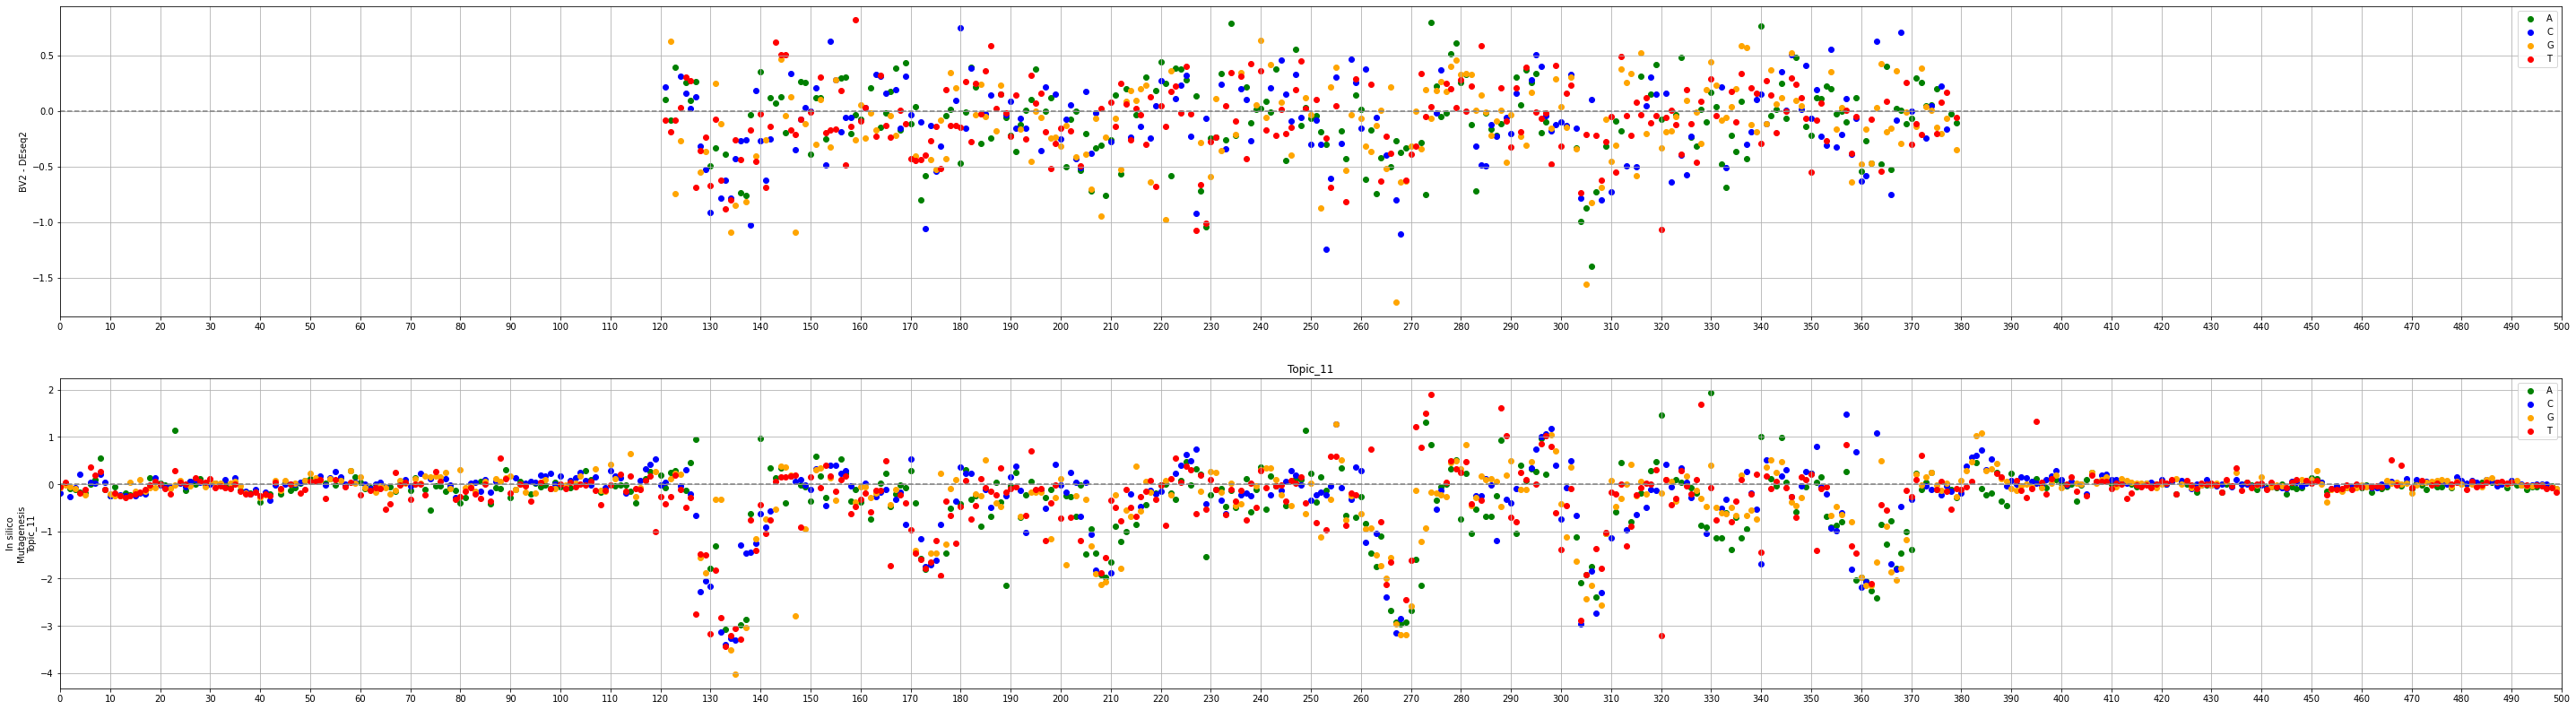

In [64]:
location = ("chr18", 61108475, 61108975) # FIRE enhancer
location_ext = (location[0], location[1]-807, location[2]+807) # extend 500 bp peaks to 2114 if needed
genomefile_path = "/staging/leuven/res_00001/genomes/mus_musculus/mm10_ucsc/fasta/mm10.fa"
seq_onehot_ext = utils.one_hot_encode_along_row_axis(BedTool.seq(location_ext, genomefile_path))

ntrack=2
fig = plt.figure(figsize=(50,ntrack*7))
seq_shape=(500,4)
cheq_seq_to_plot1 = fire_DEseq_BV2new_dict
arr_a = np.zeros(500)
arr_c = np.zeros(500)
arr_g = np.zeros(500)
arr_t = np.zeros(500)
for i,mut in enumerate(cheq_seq_to_plot1):
    if mut.endswith("A"):
        arr_a[int(mut.split("_")[0])+120]=cheq_seq_to_plot1[mut]
    if mut.endswith("C"):
        arr_c[int(mut.split("_")[0])+120]=cheq_seq_to_plot1[mut]
    if mut.endswith("G"):
        arr_g[int(mut.split("_")[0])+120]=cheq_seq_to_plot1[mut]
    if mut.endswith("T"):
        arr_t[int(mut.split("_")[0])+120]=cheq_seq_to_plot1[mut]

arr_a[arr_a == 0] = None
arr_c[arr_c == 0] = None
arr_g[arr_g == 0] = None
arr_t[arr_t == 0] = None

ax = fig.add_subplot(ntrack, 1,1)
ax.set_ylabel('BV2 - DEseq2')
ax.set_title("")
ax.scatter(range(seq_shape[0]), arr_a-2.24, label='A', color='green')
ax.scatter(range(seq_shape[0]), arr_c-2.24, label='C', color='blue')
ax.scatter(range(seq_shape[0]), arr_g-2.24, label='G', color='orange')
ax.scatter(range(seq_shape[0]), arr_t-2.24, label='T', color='red')
ax.legend()
ax.grid('on')
ax.axhline(y=0, linestyle='--', color='gray')
ax.set_xlim((0, seq_shape[0]))
_ = ax.set_xticks(np.arange(0, seq_shape[0]+1, 10))

track_no=2
topic=11
ax, A, C, G, T = utils.plot_mutagenesis_givenax(model_tmp, fig=fig, ntrack=ntrack, track_no=track_no, seq_onehot=seq_onehot_ext, topic=topic, zoom=500)
#ax, A, C, G, T = utils.plot_mutagenesis_givenax(model_dar, fig=fig, ntrack=ntrack, track_no=track_no, seq_onehot=seq_onehot, topic=topic, zoom=500)
ax.grid('on')

In [65]:
arrs = [A,C,G,T]
ISM = np.zeros((4,500))
for i, arr in enumerate(arrs):
    #arr[:927]=None
    #arr[927+259:]=None
    tmp= arr[928:928+259]
    #tmp= arr[121:121+259]
    ISM[i,121:121+259 ]=-tmp
    #ISM[ISM == 0] = None
    ISM[np.abs(ISM) ==0] = None

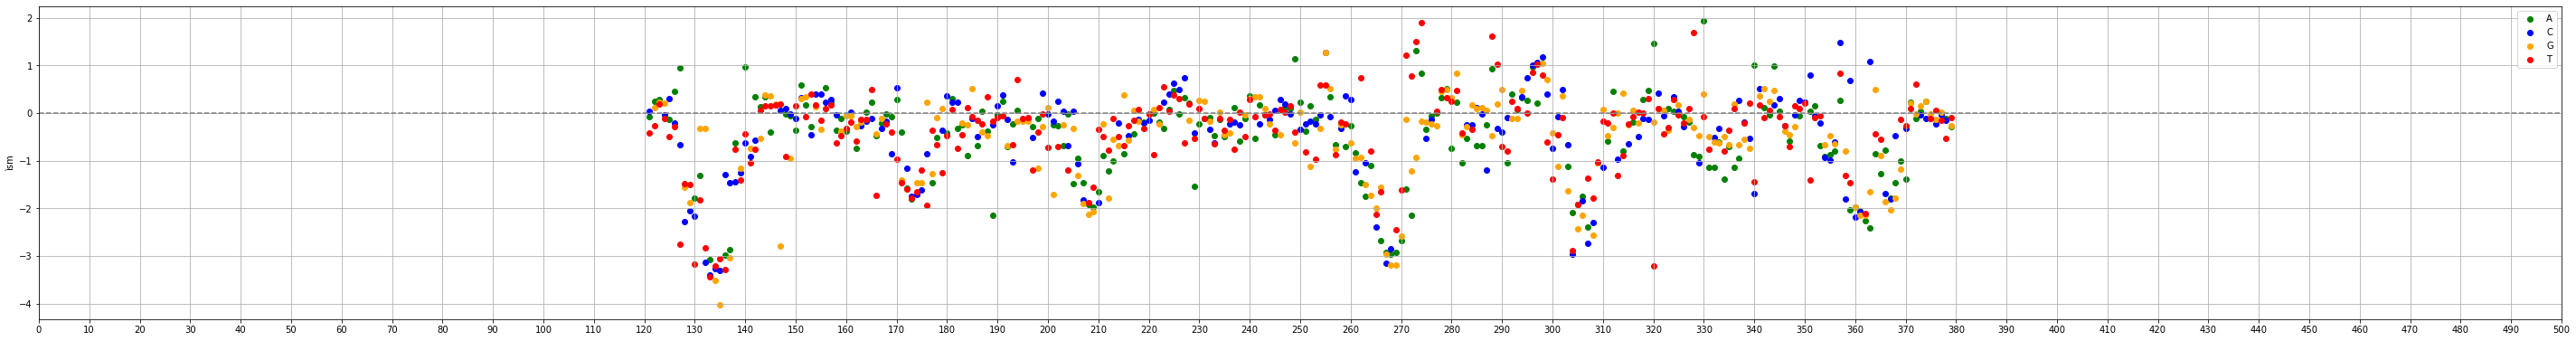

In [66]:
ntrack=2
fig = plt.figure(figsize=(50,ntrack*7))
ax = fig.add_subplot(ntrack, 1,1)
ax.set_ylabel('ìsm')
ax.set_title("")
ax.scatter(range(seq_shape[0]), ISM[0], label='A', color='green')
ax.scatter(range(seq_shape[0]), ISM[1], label='C', color='blue')
ax.scatter(range(seq_shape[0]), ISM[2], label='G', color='orange')
ax.scatter(range(seq_shape[0]), ISM[3], label='T', color='red')
ax.legend()
ax.grid('on')
ax.axhline(y=0, linestyle='--', color='gray')
ax.set_xlim((0, seq_shape[0]))
_ = ax.set_xticks(np.arange(0, seq_shape[0]+1, 10))


In [67]:
x=np.array([arr_a, arr_c, arr_g, arr_t]).flatten() - 2.24
y=ISM.flatten()
to_df = np.transpose(np.array([x,y]))

In [68]:
df_ = pd.DataFrame(to_df)
pcc = df_.corr().iloc[0][1]
#df_[205:255]

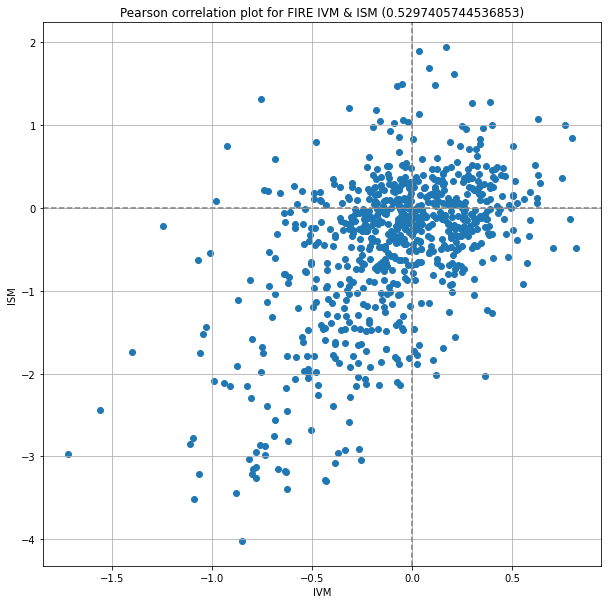

In [70]:
plt.figure(figsize=(10,10))
plt.scatter(x, y)
plt.grid('on')
plt.ylabel('ISM')
plt.xlabel('IVM')
plt.axhline(y=0, linestyle='--', color='gray')
plt.axvline(x=0, linestyle='--', color='gray')
#plt.xlim([0,np.max(x)])
plt.title('Pearson correlation plot for FIRE IVM & ISM ('+str(pcc)+')')
plt.show()